# Satellite Outer Bounds Comparison

This notebook compares different methods for computing outer bounds on satellite tracking error:
1. **Log-linearized SE(2,3)** dynamics
2. **HCW (Hill-Clohessy-Wiltshire)** linearized dynamics
3. **TH-LTV (Tschauner-Hempel Linear Time-Varying)** dynamics

The notebook performs:
- Monte Carlo simulations of burn and coast phases with disturbances
- LMI-based reachability analysis for each model
- Comparison of predicted bounds vs. actual trajectories

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

# Add repo root to path
repo_root = None
for path in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
    if (path / "cp_reach").exists():
        repo_root = path
        break
if repo_root is None:
    raise RuntimeError("Could not locate repo root")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from cp_reach.development.applications.satellite import invariant_set
from cp_reach.development.applications.satellite import plotting
from cp_reach.development.applications.satellite import HCW
from cp_reach.development.applications.satellite import TH_LTV
from cp_reach.development.applications.satellite import mission as sat_sim
from cp_reach.physics import rigid_body

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [ ]:
%load_ext autoreload
%autoreload 2

## 1. Define Mission Parameters

In [ ]:
# Mission parameters
thrust = 10              # N
duration = 20              # seconds
ang_vel_dist_deg = 0.001   # degrees
ang_vel_dist_rad = np.deg2rad(ang_vel_dist_deg)
gravity_err = 0.00         # m/s^2
accel_dist = 50            # m/s^2

# Control gains
Kp = 1
Kd = 1
Kpq = 1
Kdq = 1
control_gains = (Kp, Kd, Kpq, Kdq)

# Reference acceleration
acc = [thrust, 0, 0]

print(f"Mission Parameters:")
print(f"  Thrust: {thrust} N")
print(f"  Duration: {duration} s")
print(f"  Angular velocity disturbance: {ang_vel_dist_deg} deg/s")
print(f"  Acceleration disturbance: {accel_dist} m/s^2")
print(f"  Control gains: Kp={Kp}, Kd={Kd}, Kpq={Kpq}, Kdq={Kdq}")

Mission Parameters:
  Thrust: 10 N
  Duration: 20 s
  Angular velocity disturbance: 0.001 deg/s
  Acceleration disturbance: 50 m/s^2
  Control gains: Kp=1, Kd=1, Kpq=1, Kdq=1


## 2. Simulation Functions

In [ ]:
def do_burn_reference(t_vect):
    """Simulate reference burn trajectory (no disturbances)."""
    sat_burn = sat_sim.SatSimBurn()
    p_index = sat_burn.model['p_index']
    sat_burn.model['p0_dict']['w_d_phase'] = 0
    sat_burn.model['p0_dict']['w_d_freq'] = 0
    sat_burn.model['p0_dict']['w_d_amp'] = 0
    sat_burn.model['p0_dict']['a_d_amp'] = 0
    sat_burn.model['p0_dict']['thrust'] = thrust
    sat_burn.model['p0_dict']['Kp'] = Kp
    sat_burn.model['p0_dict']['Kd'] = Kd
    sat_burn.model['p0_dict']['Kpq'] = Kpq
    sat_burn.model['p0_dict']['Kdq'] = Kdq
    
    res = sat_burn.simulate(t_vect, integrator='rk')
    return res

def do_burn_monte_carlo(t_vect, n_runs=10):
    """Run Monte Carlo simulation with disturbances."""
    sat_burn = sat_sim.SatSimBurn()
    data = []
    for i in range(n_runs):
        p_index = sat_burn.model['p_index']
        sat_burn.model['p0_dict']['w_d_x_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_y_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_z_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_freq'] = 10**np.random.uniform(-2, 1)
        sat_burn.model['p0_dict']['w_d_amp'] = ang_vel_dist_rad
        sat_burn.model['p0_dict']['a_d_amp'] = accel_dist
        sat_burn.model['p0_dict']['thrust'] = thrust
        sat_burn.model['p0_dict']['Kp'] = Kp
        sat_burn.model['p0_dict']['Kd'] = Kd
        sat_burn.model['p0_dict']['Kpq'] = Kpq
        sat_burn.model['p0_dict']['Kdq'] = Kdq

        res = sat_burn.simulate(t_vect, integrator='rk')
        data.append(res)
    return data

In [ ]:
def do_coast_reference(data_burn_ref, t_vect):
    """Simulate reference coast trajectory."""
    sat_burn = sat_sim.SatSimBurn()
    sat_coast = sat_sim.SatSimCoast()
    sat_coast.model['p0_dict']['thrust'] = 0
    # Initial conditions from end of burn
    for k in sat_coast.model['x0_dict']:
        sat_coast.model['x0_dict'][k] = data_burn_ref['xf'][sat_burn.model['x_index'][k], -1].full().squeeze()
    return sat_coast.simulate(t_vect, integrator='cvodes')

def do_coast_sim(data_burn, t_vect):
    """Simulate coast for Monte Carlo runs."""
    data = []
    sat_burn = sat_sim.SatSimBurn()
    for r_burn in data_burn:
        sat_coast = sat_sim.SatSimCoast()
        # Initial conditions from end of burn
        for k in sat_coast.model['x0_dict']:
            sat_coast.model['x0_dict'][k] = r_burn['xf'][sat_burn.model['x_index'][k], -1].full().squeeze()
        res = sat_coast.simulate(t_vect, integrator='cvodes')
        data.append(res)
    return data

## 3. Run Monte Carlo Simulations

In [ ]:
# Burn phase simulation
print("Running burn phase simulations...")
t_burn_vect = np.arange(0, duration, 0.01)
data_burn_ref = do_burn_reference(t_burn_vect)
data_burn = do_burn_monte_carlo(t_vect=t_burn_vect, n_runs=100)
print(f"Completed {len(data_burn)} Monte Carlo runs")

Running burn phase simulations...
Completed 100 Monte Carlo runs


In [ ]:
# Coast phase simulation
print("Running coast phase simulations...")
t_coast = np.arange(0, 3*24*3600, 60)  # 3 days, 60s time step
data_coast_ref = do_coast_reference(data_burn_ref=data_burn_ref, t_vect=t_coast)
data_coast = do_coast_sim(data_burn=data_burn, t_vect=t_coast)
print("Coast phase complete")

Running coast phase simulations...
Coast phase complete


## 4. Visualize Orbits

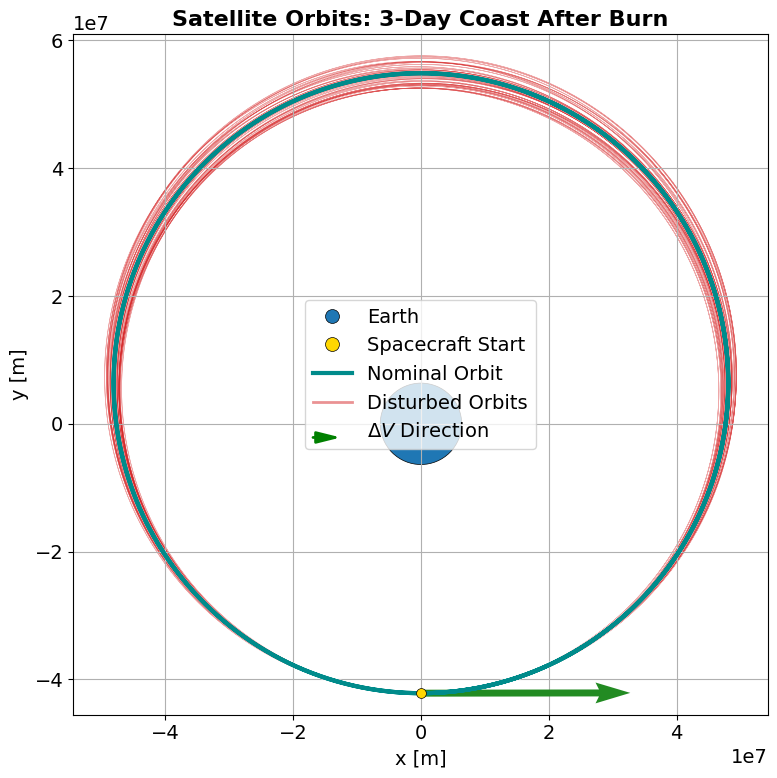

In [ ]:
# Set publication-quality plotting parameters
mpl.rcParams['font.size'] = 14
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is available

fig, ax = plt.subplots(figsize=(8, 8))
ax = plotting.plot_orbits(ax=ax, data_ref=data_coast_ref, data=data_coast)
ax.set_title('Satellite Orbits: 3-Day Coast After Burn', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Compute Invariant Sets

### 5.1 Log-Linearized SE(2,3) System

In [ ]:
print("Computing log-linearized invariant set...")
t0 = time.perf_counter()
xi_points, eta_points, bounds_log, sol = invariant_set.solve(
    accel_dist, acc, control_gains, num_points=1000
)
tf = time.perf_counter()
print(f"Log-linearized LMI solved in {tf-t0:.2f} seconds")
print(f"\nLog-linearized bounds (9D):")
print(bounds_log)

Computing log-linearized invariant set...
13.667656757985242
13.667815378983505
16.1046799949836
Log-linearized LMI solved in 16.11 seconds

Log-linearized bounds (9D):
[[-78.96136304  78.96136304]
 [-77.12686857  77.12686857]
 [-77.12686857  77.12686857]
 [-74.13172397  74.13172397]
 [-74.85130109  74.85130109]
 [-74.85130109  74.85130109]
 [ -0.89804962   0.89804962]
 [ -0.89804962   0.89804962]
 [ -2.78477442   2.78477442]]


### 5.2 HCW System

In [ ]:
print("Computing HCW invariant set...")
mu = 3.986e14      # [m^3/s^2] Earth gravitational parameter
r0 = 42164e3       # [m] GEO radius
ref_n = np.sqrt(mu / r0**3)  # Mean motion

hcw_sol = HCW.solve_hcw_invariant_set(ref_n, accel_dist, Kp=Kp, Kd=Kd)
mu1 = hcw_sol['mu']  # acceleration disturbance multiplier
P_hcw = hcw_sol['P']
val_hcw = mu1 * accel_dist**2 
P_hcw_scaled = P_hcw / val_hcw
hcw_points = HCW.sample_ellipsoid_boundary_6(P_hcw_scaled, n=600)

hcw_min = np.min(hcw_points, axis=1)
hcw_max = np.max(hcw_points, axis=1)
bounds_hcw = np.column_stack([hcw_min, hcw_max])

print(f"\nHCW bounds (6D):")
print(bounds_hcw)

Computing HCW invariant set...

HCW bounds (6D):
[[-78.40662663  78.40662663]
 [-78.40662631  78.40662631]
 [-78.40662624  78.40662624]
 [-73.65958058  73.65958058]
 [-73.65958092  73.65958092]
 [-73.65958123  73.65958123]]


### 5.3 TH-LTV System

In [ ]:
print("Computing TH-LTV invariant set...")
# Extract orbital parameters from reference trajectory
ref_orbit = data_burn_ref['xf'][1:7,:].T
bounds_params = TH_LTV.th_param_bounds_from_traj(ref_orbit, mu)
print(f"\nTH orbital parameter bounds:")
print(bounds_params)

t0 = time.perf_counter()
th_sol = TH_LTV.solve_YA_TH_LTV_invariant_set_from_bounds(bounds_params, accel_dist, Kp=Kp, Kd=Kd)
mu1 = th_sol['mu']  # acceleration disturbance multiplier
P_th = th_sol['P']
val_th = mu1 * accel_dist**2
P_th_scaled = P_th / val_th
th_points = TH_LTV.sample_ellipsoid_boundary_6(P_th_scaled, n=1000)

th_min = np.min(th_points, axis=1)
th_max = np.max(th_points, axis=1)
bounds_th = np.column_stack([th_min, th_max])

tf = time.perf_counter()
print(f"TH-LTV LMI solved in {tf-t0:.2f} seconds")
print(f"\nTH-LTV bounds (6D):")
print(bounds_th)

Computing TH-LTV invariant set...
[7.28109288e-05 7.28133004e-05 7.28156721e-05 ... 7.75471900e-05
 7.75495617e-05 7.75519333e-05] [-0.00000000e+00  2.32268867e-17  4.59523030e-17 ... -1.04131227e-12
 -1.04242392e-12 -1.04353620e-12] 0.008157291257623406

TH orbital parameter bounds:
{'a_min': 5.301431346076512e-09, 'a_max': 6.014302365635088e-09, 'b_min': 7.281092875438764e-05, 'b_max': 7.755193334556585e-05, 'c_min': -1.0435361953309445e-12, 'c_max': 5.485111579966143e-16, 'd_min': 5.068049235788115e-09, 'd_max': 5.571022504417082e-09, 'h_mean': 133657771817.33875, 'k': 0.008157291257623406}
TH-LTV LMI solved in 1.31 seconds

TH-LTV bounds (6D):
[[-78.55773965  78.52209954]
 [-78.55773922  78.52209911]
 [-78.55774026  78.52210015]
 [-73.63896653  73.65920918]
 [-73.63896656  73.65920921]
 [-73.63896644  73.63896644]]


## 6. Compare Bounds on Burn Phase

Plot tracking errors during burn phase with predicted bounds from each method.

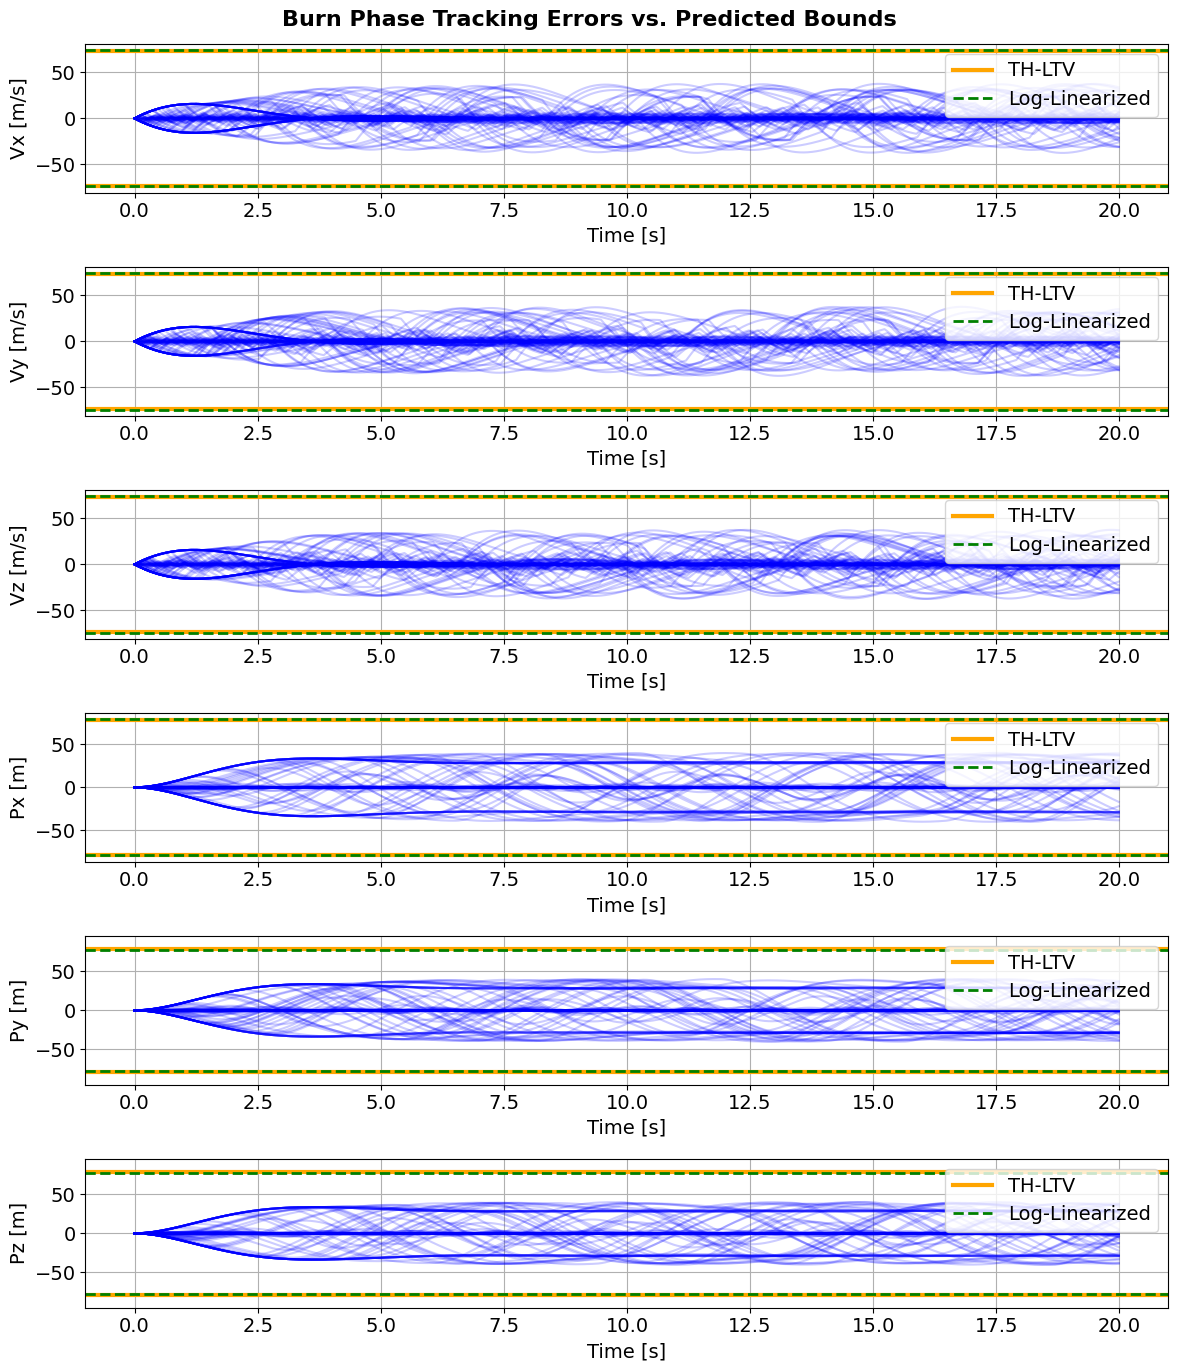

In [ ]:
def burn_plotting(data_burn, bounds_log, bounds_th):
    """Plot burn phase errors with bounds from different methods."""
    fig, axes = plt.subplots(6, 1, figsize=(12, 14))
    fig.suptitle('Burn Phase Tracking Errors vs. Predicted Bounds', fontsize=16, fontweight='bold')
    
    # Velocity errors
    ax_idx = 0
    data_idx = 3
    plotting.plot_burn_delta_vx_error(axes[ax_idx], data_burn)
    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=3, color='orange', label='TH-LTV')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=3, color='orange')
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', lw=2, color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], lw=2, color='green', linestyle='--')
    axes[ax_idx].legend(loc='upper right')

    ax_idx = 1
    data_idx = 4
    plotting.plot_burn_delta_vy_error(axes[ax_idx], data_burn)
    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=3, color='orange', label='TH-LTV')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=3, color='orange')
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', lw=2, color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], lw=2, color='green', linestyle='--')
    axes[ax_idx].legend(loc='upper right')

    ax_idx = 2
    data_idx = 5
    plotting.plot_burn_delta_vz_error(axes[ax_idx], data_burn)
    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=3, color='orange', label='TH-LTV')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=3, color='orange')
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', lw=2, color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], lw=2, color='green', linestyle='--')
    axes[ax_idx].legend(loc='upper right')

    # Position errors
    ax_idx = 3
    data_idx = 0
    plotting.plot_burn_x_error(axes[ax_idx], data_burn)
    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=3, color='orange', label='TH-LTV')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=3, color='orange')
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', lw=2, color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], lw=2, color='green', linestyle='--')
    axes[ax_idx].legend(loc='upper right')

    ax_idx = 4
    data_idx = 1
    plotting.plot_burn_y_error(axes[ax_idx], data_burn)
    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=3, color='orange', label='TH-LTV')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=3, color='orange')
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', lw=2, color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], lw=2, color='green', linestyle='--')
    axes[ax_idx].legend(loc='upper right')
    
    # Adjust y-limits to show all bounds
    ax = axes[ax_idx]
    y0, y1 = ax.get_ylim()
    vals = [bounds_th[data_idx, 0], bounds_th[data_idx, 1],
            bounds_log[data_idx, 0], bounds_log[data_idx, 1], y0, y1]
    lo, hi = min(vals), max(vals)
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    ax.set_ylim(lo - pad, hi + pad)

    ax_idx = 5
    data_idx = 2
    plotting.plot_burn_z_error(axes[ax_idx], data_burn)
    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=3, color='orange', label='TH-LTV')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=3, color='orange')
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', lw=2, color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], lw=2, color='green', linestyle='--')
    axes[ax_idx].legend(loc='upper right')
    
    # Adjust y-limits
    ax = axes[ax_idx]
    y0, y1 = ax.get_ylim()
    vals = [bounds_th[data_idx, 0], bounds_th[data_idx, 1],
            bounds_log[data_idx, 0], bounds_log[data_idx, 1], y0, y1]
    lo, hi = min(vals), max(vals)
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    ax.set_ylim(lo - pad, hi + pad)

    plt.tight_layout()
    return fig

fig = burn_plotting(data_burn, bounds_log, bounds_th)
plt.show()

## 7. Summary

This notebook demonstrated:
- **Monte Carlo simulation** of satellite burn and coast phases with disturbances
- **Three reachability methods** for computing outer bounds:
  - Log-linearized SE(2,3) dynamics (most accurate for attitude-coupled dynamics)
  - HCW linearized dynamics (classical approach)
  - TH-LTV dynamics (time-varying orbital mechanics)
- **Comparison** showing which method provides tighter bounds for different state variables

The log-linearized approach generally provides the tightest bounds for systems with significant attitude-translation coupling, while TH-LTV captures time-varying orbital effects.